For fine-tuning we have 3 datasets: train, validation and holdout

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn

from scipy import interp
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence
import keras.backend as K

from config import *
from utils import specificity, sensitivity, balanced_accuracy, IntensityRescale, sagittal_flip, translate

Using TensorFlow backend.


In [2]:
# Start timing
start_time = time.time()

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "7"
set_session(tf.Session(config=config))

In [4]:
zero_one_normalize = True
dtype = np.float32
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions"

In [5]:
!mkdir -p $result_dir

In [6]:
# load hdf5 files and extract columns
train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset_FLAIR_lesions_filled_inclWMmask.h5', 'r')
holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset_FLAIR_lesions_filled_inclWMmask.h5', 'r')

X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [7]:
# convert data to numpy arrays
X_train = np.array(X_train, dtype=dtype)
y_train = np.array(y_train)

X_holdout = np.array(X_holdout, dtype=dtype)
y_holdout = np.array(y_holdout)

In [8]:
print("Total training set length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

print("Total holdout set length: {}".format(len(y_holdout)))
print("Number of healthy controls: {}".format(len(np.array(y_holdout)[np.array(y_holdout)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_holdout)[np.array(y_holdout)==1.])))

Total training set length: 124
Number of healthy controls: 61
Number of MS patients: 63
Total holdout set length: 23
Number of healthy controls: 10
Number of MS patients: 13


In [9]:
class CISDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        #label = np.array((batch_idx['label'] == "MS")* 1, dtype=np.int8) 
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

In [10]:
mask = None

In [11]:
intensity = IntensityRescale(masked=False)

In [12]:
if zero_one_normalize:
    cis_data = CISDataset(X_train, y_train, transform=[intensity], batch_size=4)
else:
    cis_data = CISDataset(X_train, y_train, batch_size=4)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


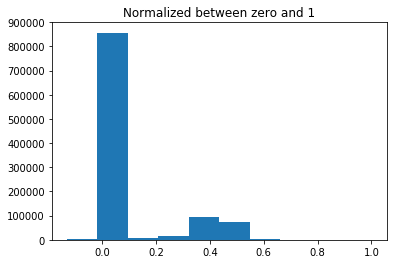

In [13]:
plt.figure()
plt.title("Normalized between zero and 1")
plt.hist(cis_data[4][0][0].flatten())
plt.show()

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


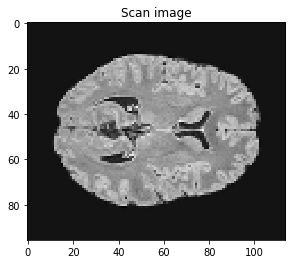

In [14]:
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(cis_data[4][0][0])[:,:,42], cmap='gray')
plt.show()

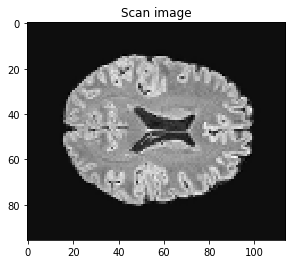

In [15]:
# TODO compare with healthy brain
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(X_train[15])[:,:,48], cmap='gray')
plt.show()

# Model

In [16]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [17]:
# load model weights
#model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model.h5"
model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model_trial_6.h5"
model = init_model(model_path, finetune=False, up_to=None)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

## Visualization

In [18]:
def visualize_weights(model):
    # Visualize weights
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)[:,:,2]
    print("W shape : ", W.shape)

    print("Weights mean {}".format(W.mean()))
    plt.figure(figsize=(20, 5))
    plt.title('conv1 weights')
    plt.imshow(make_mosaic(W, 2, 2), cmap="gray")
    plt.show()

In [19]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [20]:
def reset_weights(model):
    # Note this only used for visualization below
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)


Pre-trained model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0010960017098113894


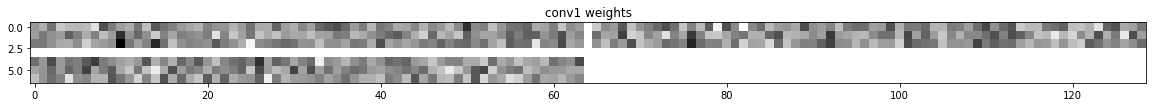

Random model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean 0.002811555750668049


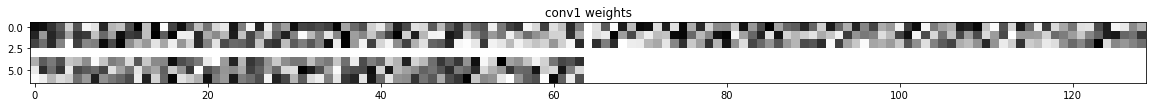

In [21]:
# Visualize weights
print("Pre-trained model layer 1 weights:")
visualize_weights(model)
model_untrained = load_model(model_path)
reset_weights(model_untrained)
print("Random model layer 1 weights:")
visualize_weights(model_untrained)

## Training

In [22]:
X_train.shape

(124, 96, 114, 96)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# split training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=77)

Trial 0
Epoch 1/200


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


27/27 [==============================] - 8s 285ms/step - loss: 1.0363 - acc: 0.4356 - val_loss: 0.8921 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial0-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 156ms/step - loss: 0.8899 - acc: 0.5736 - val_loss: 0.9956 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 4s 157ms/step - loss: 0.9265 - acc: 0.5180 - val_loss: 0.8076 - val_acc: 0.6316

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 154ms/step - loss: 0.9877 - acc: 0.5458 - val_loss: 0.8561 - val_acc: 0.4737

Epoch 00004: val_acc did not improve from 0.68421
Epoch 5/200
27/27 [==============================] - 4s 156ms/step - loss: 0.8956 - acc: 0.5088 - val_loss: 0.9052 - val_acc: 0.3158

Epo

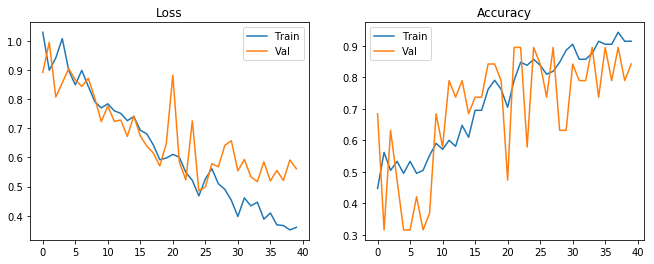

Trial 1
Epoch 1/200
27/27 [==============================] - 5s 203ms/step - loss: 0.9865 - acc: 0.5829 - val_loss: 0.8629 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial1-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 156ms/step - loss: 0.9644 - acc: 0.5180 - val_loss: 0.8764 - val_acc: 0.5263

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 4s 161ms/step - loss: 0.9341 - acc: 0.4717 - val_loss: 0.9817 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 164ms/step - loss: 0.9021 - acc: 0.5273 - val_loss: 0.9387 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.68421
Epoch 5/200
27/27 [==============================] - 4s 164ms/step - loss: 0.8599 - acc: 0.4727 - val_loss: 0.9187 - 

27/27 [==============================] - 4s 157ms/step - loss: 0.3909 - acc: 0.9259 - val_loss: 0.5860 - val_acc: 0.7895

Epoch 00043: val_acc did not improve from 0.89474
Epoch 44/200
27/27 [==============================] - 4s 164ms/step - loss: 0.3749 - acc: 0.9166 - val_loss: 0.5425 - val_acc: 0.8421

Epoch 00044: val_acc did not improve from 0.89474
Epoch 45/200
27/27 [==============================] - 4s 157ms/step - loss: 0.3102 - acc: 0.9444 - val_loss: 0.5256 - val_acc: 0.8947

Epoch 00045: val_acc did not improve from 0.89474
Epoch 46/200
27/27 [==============================] - 4s 165ms/step - loss: 0.3683 - acc: 0.9073 - val_loss: 0.5598 - val_acc: 0.7895

Epoch 00046: val_acc did not improve from 0.89474
Epoch 47/200
27/27 [==============================] - 4s 162ms/step - loss: 0.3857 - acc: 0.8980 - val_loss: 0.5125 - val_acc: 0.8947

Epoch 00047: val_acc did not improve from 0.89474
Epoch 48/200
27/27 [==============================] - 4s 159ms/step - loss: 0.3360 - acc

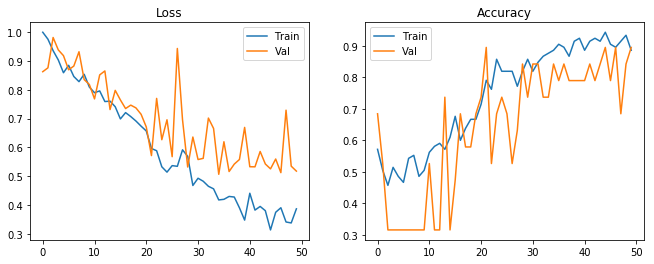

Trial 2
Epoch 1/200
27/27 [==============================] - 5s 198ms/step - loss: 1.0703 - acc: 0.4542 - val_loss: 1.1003 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial2-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 155ms/step - loss: 0.9996 - acc: 0.4449 - val_loss: 0.8272 - val_acc: 0.6842

Epoch 00002: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial2-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 164ms/step - loss: 0.9831 - acc: 0.4449 - val_loss: 0.9741 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 160ms/step - loss: 0.9164 - acc: 0.4820 - val_loss: 0.9328 - val_acc: 0.3158

Epoch 00004: val_acc did 


Epoch 00040: val_acc did not improve from 0.94737
Epoch 41/200
27/27 [==============================] - 5s 168ms/step - loss: 0.4030 - acc: 0.9073 - val_loss: 0.5442 - val_acc: 0.8947

Epoch 00041: val_acc did not improve from 0.94737
Epoch 42/200
27/27 [==============================] - 4s 163ms/step - loss: 0.3679 - acc: 0.9259 - val_loss: 0.5706 - val_acc: 0.8421

Epoch 00042: val_acc did not improve from 0.94737
Epoch 43/200
27/27 [==============================] - 4s 155ms/step - loss: 0.3876 - acc: 0.8702 - val_loss: 0.6084 - val_acc: 0.6842

Epoch 00043: val_acc did not improve from 0.94737
Epoch 44/200
27/27 [==============================] - 4s 164ms/step - loss: 0.3723 - acc: 0.8980 - val_loss: 0.5102 - val_acc: 0.8947

Epoch 00044: val_acc did not improve from 0.94737
Epoch 45/200
27/27 [==============================] - 4s 156ms/step - loss: 0.3595 - acc: 0.8980 - val_loss: 0.5703 - val_acc: 0.7895

Epoch 00045: val_acc did not improve from 0.94737
Epoch 46/200
27/27 [====

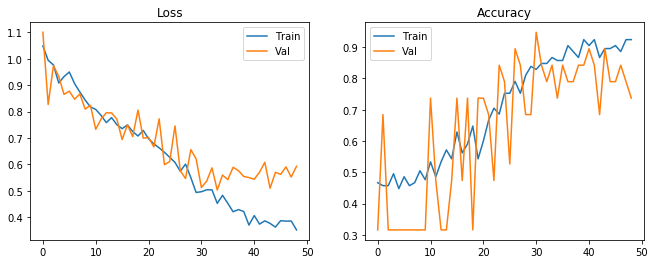

Trial 3
Epoch 1/200
27/27 [==============================] - 6s 207ms/step - loss: 1.0310 - acc: 0.5088 - val_loss: 0.9299 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial3-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 156ms/step - loss: 0.9617 - acc: 0.5458 - val_loss: 0.8494 - val_acc: 0.7368

Epoch 00002: val_acc improved from 0.31579 to 0.73684, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial3-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 159ms/step - loss: 0.8851 - acc: 0.5273 - val_loss: 1.0777 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.73684
Epoch 4/200
27/27 [==============================] - 4s 157ms/step - loss: 0.9393 - acc: 0.5551 - val_loss: 0.8173 - val_acc: 0.6842

Epoch 00004: val_acc did 

27/27 [==============================] - 4s 163ms/step - loss: 0.3307 - acc: 0.9073 - val_loss: 0.5757 - val_acc: 0.8421

Epoch 00042: val_acc did not improve from 0.84211
Epoch 43/200
27/27 [==============================] - 6s 228ms/step - loss: 0.4396 - acc: 0.8991 - val_loss: 1.0143 - val_acc: 0.5789

Epoch 00043: val_acc did not improve from 0.84211
Epoch 44/200
27/27 [==============================] - 4s 162ms/step - loss: 0.3686 - acc: 0.9259 - val_loss: 0.6309 - val_acc: 0.6842

Epoch 00044: val_acc did not improve from 0.84211
Epoch 45/200
27/27 [==============================] - 4s 165ms/step - loss: 0.3186 - acc: 0.9629 - val_loss: 0.6130 - val_acc: 0.7895

Epoch 00045: val_acc did not improve from 0.84211
Epoch 46/200
27/27 [==============================] - 4s 163ms/step - loss: 0.3394 - acc: 0.9166 - val_loss: 0.6397 - val_acc: 0.6842

Epoch 00046: val_acc did not improve from 0.84211
Epoch 47/200
27/27 [==============================] - 4s 156ms/step - loss: 0.3147 - acc

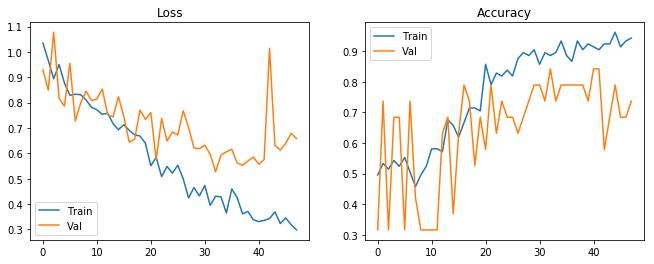

Trial 4
Epoch 1/200
27/27 [==============================] - 6s 212ms/step - loss: 0.9855 - acc: 0.5005 - val_loss: 1.0644 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial4-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 165ms/step - loss: 0.9713 - acc: 0.5098 - val_loss: 0.8080 - val_acc: 0.6842

Epoch 00002: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial4-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 158ms/step - loss: 0.9463 - acc: 0.5644 - val_loss: 0.8453 - val_acc: 0.7368

Epoch 00003: val_acc improved from 0.68421 to 0.73684, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial4-improvement-BEST.hdf5
Epoch 4/200
27/27

Epoch 41/200
27/27 [==============================] - 4s 162ms/step - loss: 0.4237 - acc: 0.8713 - val_loss: 0.5374 - val_acc: 0.8947

Epoch 00041: val_acc did not improve from 0.89474
Epoch 42/200
27/27 [==============================] - 8s 308ms/step - loss: 0.3719 - acc: 0.8980 - val_loss: 0.6018 - val_acc: 0.7368

Epoch 00042: val_acc did not improve from 0.89474
Epoch 43/200
27/27 [==============================] - 4s 161ms/step - loss: 0.3815 - acc: 0.8980 - val_loss: 0.5586 - val_acc: 0.8421

Epoch 00043: val_acc did not improve from 0.89474
Epoch 44/200
27/27 [==============================] - 4s 163ms/step - loss: 0.3992 - acc: 0.8888 - val_loss: 0.6307 - val_acc: 0.7895

Epoch 00044: val_acc did not improve from 0.89474
Epoch 45/200
27/27 [==============================] - 4s 162ms/step - loss: 0.3689 - acc: 0.9166 - val_loss: 0.4788 - val_acc: 0.8947

Epoch 00045: val_acc did not improve from 0.89474
Epoch 46/200
27/27 [==============================] - 4s 156ms/step - loss:

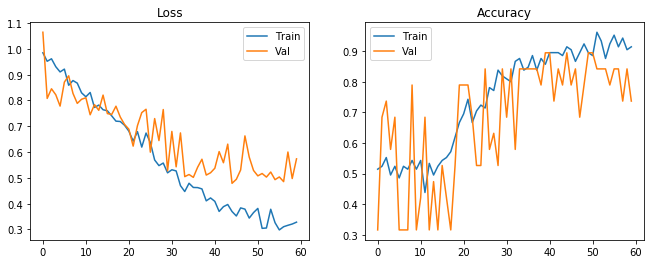

Trial 5
Epoch 1/200
27/27 [==============================] - 6s 222ms/step - loss: 1.0840 - acc: 0.4902 - val_loss: 0.8396 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial5-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 158ms/step - loss: 0.9754 - acc: 0.4810 - val_loss: 0.9935 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 4s 162ms/step - loss: 0.9863 - acc: 0.3800 - val_loss: 0.9061 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 165ms/step - loss: 0.8923 - acc: 0.4810 - val_loss: 0.8730 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.68421
Epoch 5/200
27/27 [==============================] - 4s 166ms/step - loss: 0.9045 - acc: 0.5283 - val_loss: 0.9034 - 

27/27 [==============================] - 5s 167ms/step - loss: 0.4305 - acc: 0.8610 - val_loss: 0.5066 - val_acc: 0.8421

Epoch 00042: val_acc did not improve from 0.89474
Epoch 43/200
27/27 [==============================] - 4s 155ms/step - loss: 0.3809 - acc: 0.9166 - val_loss: 0.5307 - val_acc: 0.8947

Epoch 00043: val_acc did not improve from 0.89474
Epoch 44/200
27/27 [==============================] - 4s 163ms/step - loss: 0.3670 - acc: 0.9444 - val_loss: 0.5388 - val_acc: 0.7895

Epoch 00044: val_acc did not improve from 0.89474
Epoch 45/200
27/27 [==============================] - 4s 162ms/step - loss: 0.3318 - acc: 0.9444 - val_loss: 0.5092 - val_acc: 0.8421

Epoch 00045: val_acc did not improve from 0.89474
Epoch 46/200
27/27 [==============================] - 4s 158ms/step - loss: 0.3633 - acc: 0.8888 - val_loss: 0.5660 - val_acc: 0.7895

Epoch 00046: val_acc did not improve from 0.89474
Epoch 00046: early stopping


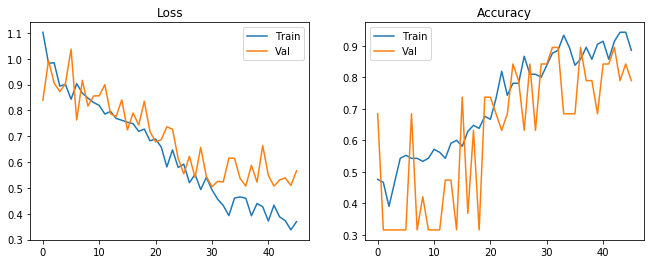

Trial 6
Epoch 1/200
27/27 [==============================] - 6s 226ms/step - loss: 1.0821 - acc: 0.4727 - val_loss: 0.9103 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial6-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 154ms/step - loss: 0.9253 - acc: 0.5458 - val_loss: 1.0319 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 4s 160ms/step - loss: 1.0749 - acc: 0.4995 - val_loss: 0.7388 - val_acc: 0.6842

Epoch 00003: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial6-improvement-BEST.hdf5
Epoch 4/200
27/27 [==============================] - 4s 161ms/step - loss: 0.9432 - acc: 0.4912 - val_loss: 0.8792 - val_acc: 0.3158

Epoch 00004: val_acc did 

27/27 [==============================] - 4s 162ms/step - loss: 0.3605 - acc: 0.8980 - val_loss: 0.5564 - val_acc: 0.8421

Epoch 00042: val_acc did not improve from 0.89474
Epoch 43/200
27/27 [==============================] - 5s 172ms/step - loss: 0.3979 - acc: 0.9073 - val_loss: 0.6115 - val_acc: 0.7895

Epoch 00043: val_acc did not improve from 0.89474
Epoch 00043: early stopping


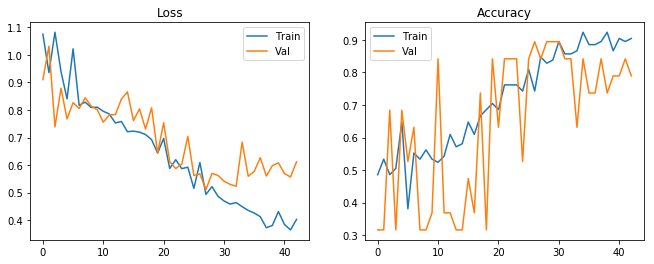

Trial 7
Epoch 1/200
27/27 [==============================] - 10s 389ms/step - loss: 1.1099 - acc: 0.4542 - val_loss: 0.9805 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial7-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 155ms/step - loss: 0.9463 - acc: 0.4995 - val_loss: 0.8766 - val_acc: 0.6842

Epoch 00002: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial7-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 155ms/step - loss: 0.9626 - acc: 0.5088 - val_loss: 0.8954 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 163ms/step - loss: 0.8989 - acc: 0.4449 - val_loss: 0.9385 - val_acc: 0.3158

Epoch 00004: val_acc did

/home/fabiane/.local/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (2.002150). Check your callbacks.
  % delta_t_median)
/home/fabiane/.local/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.001670). Check your callbacks.
  % delta_t_median)


27/27 [==============================] - 8s 295ms/step - loss: 0.4090 - acc: 0.8795 - val_loss: 0.5928 - val_acc: 0.6842

Epoch 00036: val_acc did not improve from 0.84211
Epoch 37/200
27/27 [==============================] - 7s 264ms/step - loss: 0.3751 - acc: 0.9166 - val_loss: 0.5809 - val_acc: 0.7368

Epoch 00037: val_acc did not improve from 0.84211
Epoch 38/200
27/27 [==============================] - 4s 156ms/step - loss: 0.3468 - acc: 0.9166 - val_loss: 0.7681 - val_acc: 0.6316

Epoch 00038: val_acc did not improve from 0.84211
Epoch 39/200
27/27 [==============================] - 4s 164ms/step - loss: 0.3754 - acc: 0.9259 - val_loss: 0.6086 - val_acc: 0.6842

Epoch 00039: val_acc did not improve from 0.84211
Epoch 40/200
27/27 [==============================] - 4s 159ms/step - loss: 0.4931 - acc: 0.8342 - val_loss: 0.7029 - val_acc: 0.6316

Epoch 00040: val_acc did not improve from 0.84211
Epoch 41/200
27/27 [==============================] - 4s 166ms/step - loss: 0.4047 - acc

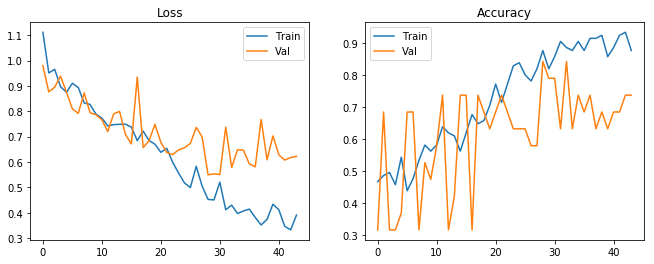

Trial 8
Epoch 1/200
27/27 [==============================] - 6s 227ms/step - loss: 1.0464 - acc: 0.5551 - val_loss: 0.9708 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial8-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 162ms/step - loss: 0.9551 - acc: 0.5283 - val_loss: 0.9870 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 5s 169ms/step - loss: 0.9267 - acc: 0.5273 - val_loss: 0.9354 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.31579
Epoch 4/200
27/27 [==============================] - 5s 167ms/step - loss: 0.9090 - acc: 0.4995 - val_loss: 0.8525 - val_acc: 0.7368

Epoch 00004: val_acc improved from 0.31579 to 0.73684, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-tria

27/27 [==============================] - 4s 165ms/step - loss: 0.3542 - acc: 0.9351 - val_loss: 0.6554 - val_acc: 0.6842

Epoch 00041: val_acc did not improve from 0.94737
Epoch 42/200
27/27 [==============================] - 10s 386ms/step - loss: 0.3415 - acc: 0.9259 - val_loss: 0.5061 - val_acc: 0.8947

Epoch 00042: val_acc did not improve from 0.94737
Epoch 43/200
27/27 [==============================] - 5s 184ms/step - loss: 0.3459 - acc: 0.9166 - val_loss: 0.4751 - val_acc: 0.8947

Epoch 00043: val_acc did not improve from 0.94737
Epoch 44/200
27/27 [==============================] - 4s 164ms/step - loss: 0.3357 - acc: 0.9073 - val_loss: 0.5048 - val_acc: 0.8947

Epoch 00044: val_acc did not improve from 0.94737
Epoch 45/200
27/27 [==============================] - 4s 165ms/step - loss: 0.3442 - acc: 0.9166 - val_loss: 0.5325 - val_acc: 0.8947

Epoch 00045: val_acc did not improve from 0.94737
Epoch 46/200
27/27 [==============================] - 4s 157ms/step - loss: 0.2859 - ac

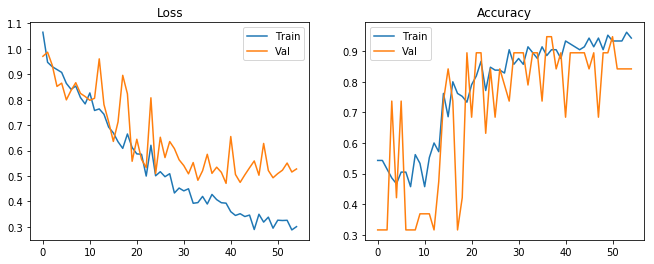

Trial 9
Epoch 1/200
27/27 [==============================] - 6s 239ms/step - loss: 1.0210 - acc: 0.4902 - val_loss: 1.0822 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/weights-augm-trial9-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 163ms/step - loss: 1.0004 - acc: 0.4820 - val_loss: 1.0218 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 4s 160ms/step - loss: 0.9449 - acc: 0.5190 - val_loss: 0.8998 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.31579
Epoch 4/200
27/27 [==============================] - 4s 155ms/step - loss: 0.8737 - acc: 0.5273 - val_loss: 0.8866 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.31579
Epoch 5/200
27/27 [==============================] - 4s 165ms/step - loss: 0.9035 - acc: 0.4449 - val_loss: 1.0196 - 

27/27 [==============================] - 4s 156ms/step - loss: 0.3826 - acc: 0.9259 - val_loss: 0.5464 - val_acc: 0.7368

Epoch 00039: val_acc did not improve from 0.89474
Epoch 40/200
27/27 [==============================] - 4s 159ms/step - loss: 0.4421 - acc: 0.8713 - val_loss: 0.5295 - val_acc: 0.8421

Epoch 00040: val_acc did not improve from 0.89474
Epoch 41/200
27/27 [==============================] - 7s 244ms/step - loss: 0.4547 - acc: 0.8795 - val_loss: 0.5374 - val_acc: 0.8421

Epoch 00041: val_acc did not improve from 0.89474
Epoch 42/200
27/27 [==============================] - 4s 156ms/step - loss: 0.3620 - acc: 0.9259 - val_loss: 0.5149 - val_acc: 0.8947

Epoch 00042: val_acc did not improve from 0.89474
Epoch 43/200
27/27 [==============================] - 4s 165ms/step - loss: 0.4012 - acc: 0.8805 - val_loss: 0.5390 - val_acc: 0.8947

Epoch 00043: val_acc did not improve from 0.89474
Epoch 44/200
27/27 [==============================] - 4s 161ms/step - loss: 0.4133 - acc

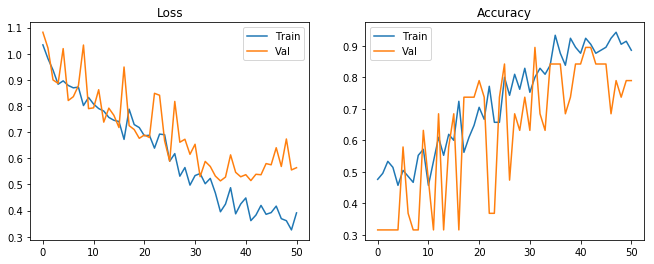

Training Time: 0.0h:40.0m:12.518653154373169s
Validation final accuracies: 
 [0.8421052631578947, 0.8947368421052632, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7894736842105263, 0.7894736842105263, 0.7368421052631579, 0.8421052631578947, 0.7894736842105263]
Validation final accuracies mean: 0.7894736842105263
Validation best accuracies: 
 [0.8947368421052632, 0.8947368421052632, 0.9473684210526315, 0.8421052631578947, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8421052631578947, 0.9473684210526315, 0.8947368421052632]
Validation best accuracies mean: 0.8947368421052632
Validation balanced accuracies: 
 [0.7948717948717949, 0.8333333333333333, 0.717948717948718, 0.6730769230769231, 0.7628205128205128, 0.8012820512820513, 0.8012820512820513, 0.717948717948718, 0.7948717948717949, 0.7115384615384616]
Validation balanced accuracies mean: 0.7608974358974359
Validation final sensitivities: 
 [0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.

In [25]:
# training args
lr = 0.0008
lr_decay = 0.002
transforms = [intensity, sagittal_flip, translate]

num_trials = 10
store_models = True

# callbacks
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
max_acc = []

for i in range(num_trials):
    print("Trial %i" %i)
    
    # init model
    model = init_model(model_path, finetune=False, up_to=None)    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
    
    # callbacks
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')
    if store_models:
        result_path = os.path.join(result_dir, "weights-augm-trial%i-improvement-BEST.hdf5" %i)
        model_checkpoint = ModelCheckpoint(result_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
        callbacks = [earlystop, model_checkpoint]
    else:
        callbacks = [earlystop]
        
    train_loader = CISDataset(X_train, y_train, transform=transforms, batch_size=b, shuffle=True)
    val_loader = CISDataset(X_val, y_val, transform=[intensity], batch_size=1, shuffle=False)
    
    # Start training
    history = model.fit_generator(train_loader,
                        epochs=num_epochs,
                        verbose=1,
                        validation_data=val_loader,
                        callbacks=callbacks)
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Val"])
    plt.title("Accuracy")
    plt.show()
    # Evaluation
    y_pred = model.predict_generator(val_loader)
    #y_true = [item for sublist in [val_loader[batch_idx][1] for batch_idx in range(len(val_loader))] for item in sublist]
    bal_acc = balanced_accuracy(y_val, y_pred>0.5)
    sens = sensitivity(y_val, y_pred>0.5)
    spec = specificity(y_val, y_pred>0.5)
    # Store results
    accuracies.append(history.history["val_acc"][-1])
    balanced_accuracies.append(bal_acc)
    max_acc.append(np.max(history.history["val_acc"]))
    sensitivities.append(sens)
    specificities.append(spec)

training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))

print("Validation final accuracies: \n {}".format(accuracies))
print("Validation final accuracies mean: {}".format(np.mean(accuracies)))
print("Validation best accuracies: \n {}".format(max_acc))
print("Validation best accuracies mean: {}".format(np.mean(max_acc)))
print("Validation balanced accuracies: \n {}".format(balanced_accuracies))
print("Validation balanced accuracies mean: {}".format(np.mean(balanced_accuracies)))
print("Validation final sensitivities: \n {}".format(sensitivities))
print("Validation final sensitivities' mean: {}".format(np.mean(sensitivities)))
print("Validation final specificities: \n {}".format(specificities))
print("Validation final specificities' mean: {}".format(np.mean(specificities)))

val bal 81%

In [26]:
training_time = time.time() - start_time

# Evaluation

In [27]:
weights = ["weights-augm-trial%i-improvement-BEST.hdf5"%i for i in range(num_trials)]

In [28]:
# load holdout set
test_loader = CISDataset(X_holdout, y_holdout, transform=[intensity], batch_size=1, shuffle=False)

Fold 0


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 73.91 %
Balanced accuracy 71.15 %
Sensitivity 92.31 %
Specificity 50.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 93.08
Fold 1


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 82.61 %
Balanced accuracy 82.31 %
Sensitivity 84.62 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 91.54
Fold 2


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 82.61 %
Balanced accuracy 81.15 %
Sensitivity 92.31 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 90.77
Fold 3


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 86.96 %
Balanced accuracy 87.31 %
Sensitivity 84.62 %
Specificity 90.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 94.62
Fold 4


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 78.26 %
Balanced accuracy 76.15 %
Sensitivity 92.31 %
Specificity 60.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 93.85
Fold 5


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 78.26 %
Balanced accuracy 77.31 %
Sensitivity 84.62 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 90.77
Fold 6


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 78.26 %
Balanced accuracy 76.15 %
Sensitivity 92.31 %
Specificity 60.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 90.77
Fold 7


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 73.91 %
Balanced accuracy 72.31 %
Sensitivity 84.62 %
Specificity 60.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 90.00
Fold 8


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 82.61 %
Balanced accuracy 81.15 %
Sensitivity 92.31 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 93.08
Fold 9


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 78.26 %
Balanced accuracy 77.31 %
Sensitivity 84.62 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 90.00
######## Final results ########
Accuracy mean 79.57 %
Balanced accuracy mean 78.23 %
Sensitivity mean 88.46 %
Specificity mean 68.00 %
Mean ROC AUC score 91.85


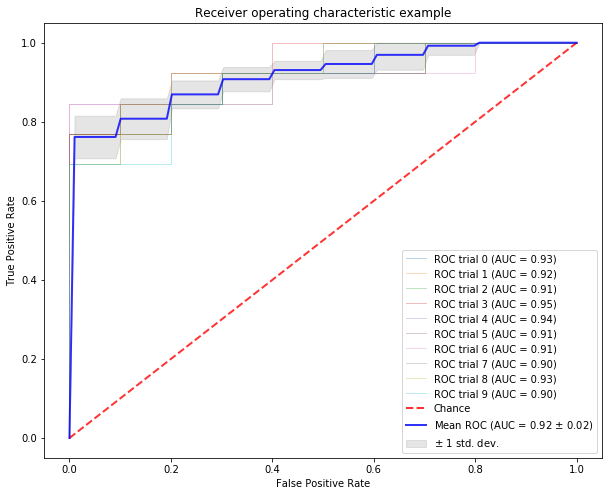

In [29]:
accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

for fold, weight in enumerate(weights):
    print("Fold {}".format(fold))
    model = load_model(model_path)
    model_dir = os.path.join(result_dir, weight)
    model.load_weights(model_dir)
    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # Evaluate
    res = model.evaluate_generator(test_loader)
    y_pred = model.predict_generator(test_loader)
    bal_acc = balanced_accuracy(y_holdout, y_pred>0.5)
    sens = sensitivity(y_holdout, y_pred>0.5)
    spec = specificity(y_holdout, y_pred>0.5)
    roc_auc = roc_auc_score(y_holdout, y_pred)
    fpr, tpr, thresholds = roc_curve(y_holdout, y_pred)   
    # Store results
    accuracies.append(res[1])
    balanced_accuracies.append(bal_acc)
    sensitivities.append(sens)
    specificities.append(spec)
    auc_scores.append(roc_auc)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    # Print results
    print("Model accuracy {:.2f} %".format(res[1]*100))
    print("Balanced accuracy {:.2f} %".format(bal_acc*100))
    print("Sensitivity {:.2f} %".format(sens*100))
    print("Specificity {:.2f} %".format(spec*100))
    print("Area Under the Receiver Operating Curve (ROC AUC score) {:.2f}".format(roc_auc*100))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC trial %d (AUC = %0.2f)' % (fold, roc_auc))
    
print("######## Final results ########")
print("Accuracy mean {:.2f} %".format(np.mean(accuracies)*100))
print("Balanced accuracy mean {:.2f} %".format(np.mean(balanced_accuracies)*100))
print("Sensitivity mean {:.2f} %".format(np.mean(sensitivities)*100))
print("Specificity mean {:.2f} %".format(np.mean(specificities)*100))
print("Mean ROC AUC score {:.2f}".format(np.mean(auc_scores)*100))

# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
#assert(mean_auc == np.mean(auc_scores))
std_auc = np.std(auc_scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (np.mean(auc_scores), std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [30]:
total_time = time.time() - start_time

In [31]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
print("Total time elapsed: {}h:{}m:{}s".format(
            total_time//3600, (total_time//60)%60, total_time%60))

Training Time: 0.0h:40.0m:12.539326906204224s
Total time elapsed: 0.0h:42.0m:15.997339725494385s


In [32]:
quit()